# Generative Adversarial Networks to generate dark data. 

We build a Generative adversarial network with the goal of generating dark data of the WFC3 camera
in the Hubble space telescope. We gather the data from the MAST archive. We separate out the files obtained into flt and flc files 
and in this notebook proceed as follows. 

1. We create the dataset we are interested in. By this we mean, we extract numpy arrays from the flt files which are in FITS format and take every such numpy image and cut it into chunks of size 64*64.

2. We try and understand the distribution of data in the images, and calculate the mean and variance of the distributions. These values will be of use later when we normalize the data. 

3. We create dataloader which we use to feed into the GAN. Note that this requires a custom loader since we work with numpy arrays.  

4. We create the discrimator and generator. The architecture for both networks is along the lines of pytorch examples. 

5. We then train the network. 

# Creating the dataset for GAN

We creat the GAN dataset consisting of numpy arrays extracted from a collection of FITS files which we have downloaded from the MAST archive. 

In [1]:
import os
import sys
from astropy.io import fits
import math
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

In [41]:
path = '/Users/johnwelliaveetil/mastDownload/flt_images'
path0 = '/Users/johnwelliaveetil/mastDownload'

We test a snippet of code that extracts the image data (numpy array) from one of the FITS files and cuts it into pieces, each of which are of size 1024*1024.

In [3]:
path_sample = '/Users/johnwelliaveetil/mastDownload/flt_images/ib918lsuq_flt.fits'
hdul = fits.open(path_sample)
hdul.info()

Filename: /Users/johnwelliaveetil/mastDownload/flt_images/ib918lsuq_flt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     262   ()      
  1  SCI           1 ImageHDU        90   (4096, 2051)   float32   
  2  ERR           1 ImageHDU        43   (4096, 2051)   float32   
  3  DQ            1 ImageHDU        35   (4096, 2051)   int16   
  4  SCI           2 ImageHDU        90   (4096, 2051)   float32   
  5  ERR           2 ImageHDU        43   (4096, 2051)   float32   
  6  DQ            2 ImageHDU        35   (4096, 2051)   int16   


In [7]:
image = hdul[1].data
image.shape

(2051, 4096)

We write a function that takes as input an image and cuts into pieces each of which are of size 1024*1024. The string s here is usually the name of the image file. The output is a dictionnary where the keys are the 'locations' of the sub images. 

In [5]:
# Get the sub images of a given image. We would like all our inputs to be 64*64
def get_sub_images(X,s):
    A = {}
    t = s[0:-5]
    a,b = X.shape
    if min(a,b) >= 64:
        m = math.floor(a/64)
        n = math.floor(b/64)
        for i in range(1,m+1):
            for j in range(1,n+1):
                temp = X[64*(i-1):64*i,64*(j-1):64*j]
                A[t + '_' + str(i)+str(j)] = temp
    return(A)      

We test the code against the sample image drawn previously. 

In [19]:
A = get_sub_images(image,'t')
#A.keys()

In [8]:
A['_11']

array([[-4.170859  ,  0.07856879, -2.1860962 , ..., -4.9314356 ,
        -3.8910155 , -4.9827304 ],
       [-2.1201289 ,  1.8412665 ,  0.0212412 , ..., -2.0411713 ,
        -1.1985307 ,  1.1639295 ],
       [-1.0004331 , -1.075549  , -4.049245  , ...,  2.1213102 ,
         1.0418154 ,  2.2270863 ],
       ...,
       [ 0.7554387 ,  0.994149  , -1.1099977 , ..., -1.1025146 ,
        -1.1983027 , -2.0856662 ],
       [ 0.91668344,  3.8717203 ,  1.961451  , ..., -2.075353  ,
         0.0729558 , -0.05109308],
       [ 0.8697649 ,  4.912557  , -1.9528145 , ..., -3.2480972 ,
        -2.0225523 , -0.09782083]], dtype=float32)

In [9]:
A['_11'].dtype

dtype('>f4')

We write a function that takes as input a dictionnary (as given by the function get_sub_images) and outputs a npy file.

In [10]:
def save_sub_image(C):
    for j in C.keys():
        name = '/Users/johnwelliaveetil/mastDownload/np_images_64' + '/' + j + '.npy'
        np.save(name,C[j])

Testing with the dictionnary A from above.......

In [12]:
save_sub_image(A)

Loading the save np images...

In [14]:
image_saved = (np.load('/Users/johnwelliaveetil/mastDownload/np_images_64/_11.npy'))

In [15]:
image_saved

array([[-4.170859  ,  0.07856879, -2.1860962 , ..., -4.9314356 ,
        -3.8910155 , -4.9827304 ],
       [-2.1201289 ,  1.8412665 ,  0.0212412 , ..., -2.0411713 ,
        -1.1985307 ,  1.1639295 ],
       [-1.0004331 , -1.075549  , -4.049245  , ...,  2.1213102 ,
         1.0418154 ,  2.2270863 ],
       ...,
       [ 0.7554387 ,  0.994149  , -1.1099977 , ..., -1.1025146 ,
        -1.1983027 , -2.0856662 ],
       [ 0.91668344,  3.8717203 ,  1.961451  , ..., -2.075353  ,
         0.0729558 , -0.05109308],
       [ 0.8697649 ,  4.912557  , -1.9528145 , ..., -3.2480972 ,
        -2.0225523 , -0.09782083]], dtype=float32)

In [16]:
image_saved.shape

(64, 64)

In [17]:
img = Image.fromarray(image_saved, 'RGB')
img.show()

Looks like that worked !

We now write a function that runs over the entire set of FITS dataset and for each element of the dataset, it extracts the image data and cuts into pieces of the required size. 

Note : We do not consider files which are empty.

In [59]:
A = os.listdir(path)
A.remove(A[60])
A.remove(A[66])
count = 0
for a in A:
#   print(count)
    hdul = fits.open(path + '/' + a)
    if len(hdul) == 7:
        image1 = hdul[1].data
        image2 = hdul[4].data
        image1 = image1.byteswap().newbyteorder()
        image2 = image2.byteswap().newbyteorder()
        s1 = a[:-5] + '_1.fits'
        s2 = a[:-5] + '_2.fits'
        C = get_sub_images(image1,s1)
        save_sub_image(C)
        D = get_sub_images(image2,s2)
        save_sub_image(D)
    if len(hdul) == 4:
        image1 = hdul[1].data
        image1 = image1.byteswap().newbyteorder()
        C = get_sub_images(image1,a)
        save_sub_image(C)        
    hdul.close()

This creates the GAN Dataset !

# Prelimnary analysis on the image data

We load random selected images from the folder and look at how the float values that make up the image vary
within a given image. 

In [29]:
B = os.listdir('/Users/johnwelliaveetil/mastDownload/np_images')

We look at a random image from the list B. 

In [21]:
i = np.random.randint(len(B))
image_sample = np.load('/Users/johnwelliaveetil/mastDownload/np_images_64'+'/' + B[0])
print(i,' ---> ' + B[i])

35599  ---> ibc131enq_flt_1_3235.npy


In [23]:
A1 = image_sample.flatten()
print('Max = %f' %A1.max())
print('Min = %f' %A1.min())
print('Mean = %f' %A1.mean())
print('Standard Deviation = %f' %A1.std())

Max = 6665.462891
Min = -5.628556
Mean = 13.547943
Standard Deviation = 191.073532


In [24]:
#image_df.describe()

In [26]:
a = np.percentile(image_sample,95)
B1 = [x for x in A1 if x < a]

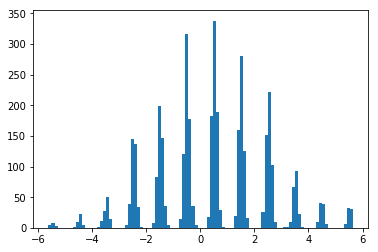

In [27]:
NBIN = 100
plt.hist(B1,NBIN)
plt.show()

We calculate the mean of the entire dataset. 

In [30]:
x = 0
count = 0
for b in B:
    tmp = np.load('/Users/johnwelliaveetil/mastDownload/np_images'+'/' + b)
    x = x + tmp.flatten().mean()
print(x/len(B))    

10.486340126658595


In [31]:
mean = x/len(B)

Calculating the variance/standard deviation of the dataset

In [32]:
y = 0
for b in B:
    tmp = np.load('/Users/johnwelliaveetil/mastDownload/np_images'+'/' + b)
    tmp = tmp.flatten()
    tmp = (tmp - mean)**2
    y = y + tmp.mean()
var = y/len(B)
std = np.sqrt(var)
print(std)

215.32743042934663


# Creating the dataloader 

Importing the relevant pytorch tools...

In [36]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


We use the dataset folder class and add a numpy loader to it to create a dataset. 

In [52]:
#Number of channels 
nc = 1

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128
 
# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

ngpu = 0

In [38]:
image_sample.reshape(1,64,64).shape

(1, 64, 64)

In [105]:
def npy_loader(path):
    tmp = np.load(path)
    tmp = (tmp - mean)/std
    tmp = tmp.reshape(1,64,64)
    sample = torch.from_numpy(tmp)
    return sample
    
dataset = dset.DatasetFolder(
    root= path0,
    loader=npy_loader,
    extensions=['.npy'],)

In [106]:
batch_size = 64
dataloader = torch.utils.data.DataLoader(dataset,batch_size = batch_size,shuffle = True)

In [44]:
real_batch = next(iter(dataloader))

In [45]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [46]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Creating the generator network

In [53]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [54]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Creating the discriminator network

In [55]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [56]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)


Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [57]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training the two networks.

In [108]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        if i <= 500:
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Add the gradients from the all-real and all-fake batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()
    
            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    
            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())
    
            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
    
            iters += 1
        else:
            break

Starting Training Loop...
[0/5][0/12216]	Loss_D: 0.0029	Loss_G: 10.5879	D(x): 0.9984	D(G(z)): 0.0013 / 0.0008
[0/5][50/12216]	Loss_D: 0.0023	Loss_G: 9.0191	D(x): 0.9982	D(G(z)): 0.0005 / 0.0003
[0/5][100/12216]	Loss_D: 0.0029	Loss_G: 7.7173	D(x): 0.9990	D(G(z)): 0.0019 / 0.0007
[0/5][150/12216]	Loss_D: 0.0018	Loss_G: 8.7359	D(x): 0.9990	D(G(z)): 0.0007 / 0.0003
[0/5][200/12216]	Loss_D: 0.0019	Loss_G: 8.1419	D(x): 0.9990	D(G(z)): 0.0009 / 0.0004
[0/5][250/12216]	Loss_D: 0.0013	Loss_G: 8.3613	D(x): 0.9993	D(G(z)): 0.0007 / 0.0003
[0/5][300/12216]	Loss_D: 0.0011	Loss_G: 8.3781	D(x): 0.9994	D(G(z)): 0.0005 / 0.0003
[0/5][350/12216]	Loss_D: 0.0020	Loss_G: 8.3069	D(x): 0.9990	D(G(z)): 0.0010 / 0.0003
[0/5][400/12216]	Loss_D: 0.0013	Loss_G: 9.1861	D(x): 0.9988	D(G(z)): 0.0001 / 0.0001
[0/5][450/12216]	Loss_D: 0.0070	Loss_G: 10.9617	D(x): 0.9959	D(G(z)): 0.0024 / 0.0004
[0/5][500/12216]	Loss_D: 0.0474	Loss_G: 9.2248	D(x): 0.9717	D(G(z)): 0.0145 / 0.0064
[1/5][0/12216]	Loss_D: 0.0756	Loss_G: 10